In [1]:
import warnings
from socceraction.data.wyscout import WyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.vaep.formula import value
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# import XGBclassifier
import numpy as np
from xgboost import XGBClassifier, plot_importance
#from scikitplot.metrics import plot_calibration_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_calibration_curve
import shap

In [2]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

# Get and store the data

In [3]:
def load_environment_vars():
    # Get the current working directory
    cwd = os.getcwd()

    # Append the .env file name
    env_path = os.path.join(cwd, '../.env')

    # Open the .env file
    with open(env_path) as f:
        # Read the lines
        lines = f.readlines()

    # Parse the key-value pairs
    for line in lines:
        # Ignore comments and empty lines
        if line.startswith('#') or not line.strip():
            continue
        # Split the line into key and value
        key, value = line.strip().split('=', 1)
        # Set the environment variable
        os.environ[key] = value

    return os.environ['WYSCOUT_API_USER'], os.environ['WYSCOUT_API_PASSWORD']

#def create_wyscout_client(username, password):
#    return wyscoutapi.WyscoutAPI(username=username, password=password)

In [4]:
# set authentication credentials as environment variables
username, password = load_environment_vars()

# or provide authentication credentials as a dictionary
api = WyscoutLoader(getter="remote", creds={"user":username, "passwd": password})

In [34]:
comp_api = api.competitions(364)

In [ ]:
api.games(364, 188989)

In [ ]:
['premier league', 'ligue 1', 'bundesliga', 'serie A', 'La liga']

In [ ]:
leagues = {'Premier League': 364,
            'Ligue 1': 412,
            'Bundesliga': 426,
            'Serie A': 524, 
            'La Liga': 795}

# iterate over the dictionary
for league, league_id in leagues.items():
    print(league, league_id)


In [31]:
leagues = [364, 412, 426, 524, 795]

In [8]:
last_premier_games = api.games(364,188989)

In [33]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

functions_labels = [
    labels.scores,
    labels.concedes
]

In [ ]:
def get_feature_game(api, game_id, home_team_id, functions_features, functions_labels):

    # get events
    last_game_event = api.events(game_id)
    spadl_df = convert_to_actions(last_game_event, home_team_id)
    
    df_actions = (spadl.add_names(spadl_df))  # add actiontype and result names

    df_actions.to_hdf('actions.h5', key=f'game_{game_id}')
                    
    gamestates = features.gamestates(df_actions,3)
    gamestates = features.play_left_to_right(gamestates, home_team_id)

    # 2. compute features
    df_features = pd.concat([fn(gamestates) for fn in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')
    # 3. compute labels
    df_labels = pd.concat([fn(df_actions) for fn in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

    # get teams
    team_name = api.teams(game_id=game_id)
    team_name.to_hdf('teams.h5', key=f'game_{game_id}')

    # get players
    player_name = api.players(game_id=game_id)
    player_name.to_hdf('players.h5', key=f'game_{game_id}')

In [ ]:
def process_features(games, api, functions_features, functions_labels):
    for row in games.itertuples():
        game_id = row.game_id
        home_team_id = row.home_team_id
        print(f'Processing game {game_id}')
        get_feature_game(api, game_id, home_team_id, functions_features, functions_labels)

In [58]:
# read all csv files in the folder and append in a single dataframe
def read_all_csv_files(folder):
    df = pd.DataFrame()
    for filename in os.listdir(folder):
        if filename.endswith('.csv'):
            df = pd.concat([df, pd.read_csv(os.path.join(folder, filename))])
    
    df.drop_duplicates(subset='game_id', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [59]:
df = read_all_csv_files("/home/pastor/projects/FriendsOfTracking/FOT/data")

In [61]:
df.head(2)

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,5251283,524,187528,2022-05-22 19:00:00,38,3192,3163
1,5251287,524,187528,2022-05-22 19:00:00,38,3191,3173


In [ ]:
def get_features_labels(games):
    dfs_features = []
    dfs_labels = []
    for row in games.itertuples():
        game_id = row.game_id
        df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
        df_features['game_id'] = game_id
        dfs_features.append(df_features)

        df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
        df_labels['game_id'] = game_id
        dfs_labels.append(df_labels)
        
    df_labels = pd.concat(dfs_labels).reset_index(drop=True)
    df_features = pd.concat(dfs_features).reset_index(drop=True)

    return df_features, df_labels

In [ ]:
def get_actions(games):
    
    dfs_actions = []
    for row in games.itertuples(): #zip(last_games['game_id'].values, last_games['home_team_id'].values):
        game_id = row.game_id
        
        #print(f'Processing game {game_id}')
        df_actions = pd.read_hdf('actions.h5', key=f'game_{game_id}')
        team_name = pd.read_hdf('teams.h5', key=f'game_{game_id}')
        player_name = pd.read_hdf('players.h5', key=f'game_{game_id}')
        df_actions = (spadl
            #df_actions#spadl
            .add_names(df_actions)  # add actiontype and result names
            .merge(team_name, how='left')  # add team names
            .merge(player_name, how='left')  # add player names
            #.sort_values(["game_id", "period_id", "action_id"])
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )
        dfs_actions.append(df_actions)
    df_actions = pd.concat(dfs_actions).reset_index(drop=True)

    return df_actions

In [28]:
api.competitions(795)
spanish_2017 = api.games(795,181144)
spanish_2017.to_csv('spanish_2017.csv')
# stores the three files actions, teams and players in a h5 file with game id as key
process_features(spanish_2017, functions_features, functions_labels)

In [36]:
features_label_sp_2017 = get_features_labels(spanish_2017)
df_features, df_labels = features_label_sp_2017
df_actions = get_actions(spanish_2017)

In [59]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_features[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_features.index)
df_predictions = pd.concat(dfs_predictions, axis=1)
#df_predictions = pd.read_csv('predictions.csv')
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)

100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


In [ ]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions.groupby('game_id'):
    df_values = value(game_predictions, game_predictions['scores'], game_predictions['concedes'])
    
    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

# Premier league

In [60]:
last_premier_games.to_csv('last_premier_games.csv', index=False)

In [61]:
last_games = last_premier_games	

If we evaluate new games we need to update our features data

In [63]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

functions_labels = [
    labels.scores,
    labels.concedes
]

for game_id, home_team_id in zip(last_games['game_id'].values, last_games['home_team_id'].values):
    print(f'Processing game {game_id}')
    last_game_event = api.events(game_id)
    spadl_df = convert_to_actions(last_game_event, home_team_id)
    team_name = api.teams(game_id=game_id)
    team_name.to_hdf('teams.h5', key=f'game_{game_id}')

    player_name = api.players(game_id=game_id)
    player_name.to_hdf('players.h5', key=f'game_{game_id}')

    df_actions = (spadl.add_names(spadl_df))  # add actiontype and result names
                  
    gamestates = features.gamestates(df_actions,3)
    gamestates = features.play_left_to_right(gamestates, home_team_id)

    #df_actions = (
    #spadl
    #.add_names(spadl_df)  # add actiontype and result names
    #.merge(team_name)  # add team names
    #.merge(player_name)  # add player names
    #)
    df_actions.to_hdf('actions.h5', key=f'game_{game_id}')

    #df_actions_atomic = atomicspadl.convert_to_atomic(df_actions)
    #df_actions_atomic = (
    #    atomicspadl
    #    .add_names(df_actions)  # add actiontype and result names
    #    .merge(team_name)  # add team names
    #    .merge(player_name)  # add player names
    #    )
    #df_actions_atomic.to_hdf('atomic_actions.h5', key=f'game_{game_id}')
    
    #gamestates = features.gamestates(df_actions,3)
    #gamestates = features.play_left_to_right(gamestates, home_team_id)

    df_features = pd.concat([fn(gamestates) for fn in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')
    # 3. compute labels
    df_labels = pd.concat([fn(df_actions) for fn in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

Processing game 5465134


Processing game 5465133
Processing game 5465132
Processing game 5465137
Processing game 5465139
Processing game 5465141
Processing game 5465135
Processing game 5465136
Processing game 5465140
Processing game 5465138
Processing game 5465128
Processing game 5465127
Processing game 5465130
Processing game 5465126
Processing game 5465131
Processing game 5465122
Processing game 5465129
Processing game 5465123
Processing game 5465124
Processing game 5465125
Processing game 5465115
Processing game 5465112
Processing game 5465121
Processing game 5465114
Processing game 5465113
Processing game 5465119
Processing game 5465118
Processing game 5465120
Processing game 5465117
Processing game 5465116
Processing game 5465110
Processing game 5465105
Processing game 5465104
Processing game 5465109
Processing game 5465108
Processing game 5465102
Processing game 5465103
Processing game 5465107
Processing game 5465111
Processing game 5465106
Processing game 5465093
Processing game 5465095
Processing game 

# Load label and features

In [67]:
dfs_features = []
dfs_labels = []
for game_id, home_team_id in zip(last_games['game_id'].values, last_games['home_team_id'].values):
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)

    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
    
df_labels = pd.concat(dfs_labels).reset_index(drop=True)
df_features = pd.concat(dfs_features).reset_index(drop=True)

# Training model

To-do:

- [] Get data from several years and from different leagues to have a more robust model

- [] - Split the data sequentially to respect the order

- [] - Get the proper evaluation metrics and make it an iterative process

- [] - Use the model to predict the outcome of new games

- Stratification: we want to keep the same distribution of classes in the train and test set, since we have two different class labels we provided a concatenation of the two labels to the stratify parameter.

In [44]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.1,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

**Note**: In a real-world scenario where more data is available, you should consider respecting the chronological order of the games to construct the training set, validation set and test set. For instance, use the data for the 2016/2017 and 2017/2018 seasons to train the models, use the data for the 2018/2019 season to tune the models, and use the data for the 2019/2020 season to obtain the results.

## Construct baseline classfiers

In [45]:
features = [
    'start_dist_to_goal_a0',
    'end_dist_to_goal_a0',
    'start_dist_to_goal_a1',
    'end_dist_to_goal_a1',
    'start_dist_to_goal_a2',
    'end_dist_to_goal_a2',
    'start_angle_to_goal_a0',
    'end_angle_to_goal_a0',
    'start_angle_to_goal_a1',
    'end_angle_to_goal_a1',
    'start_angle_to_goal_a2',
    'end_angle_to_goal_a2',
    'team_1',
    'team_2'
]
labels = ['scores',
          'concedes'
          ]

## Train classifier

In [46]:
%%time

models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model

100%|██████████| 2/2 [00:13<00:00,  6.58s/it]

CPU times: user 29.9 s, sys: 671 ms, total: 30.6 s
Wall time: 13.2 s


# Investigate feature importance

To-do:

- [] Interpret feature importance and apply the findings

- [] Understand what SHAP Values are and apply the findings to improve the model

- [] EDA on the features and how it add to the overall score

In [79]:
from xgboost import XGBClassifier, plot_importance

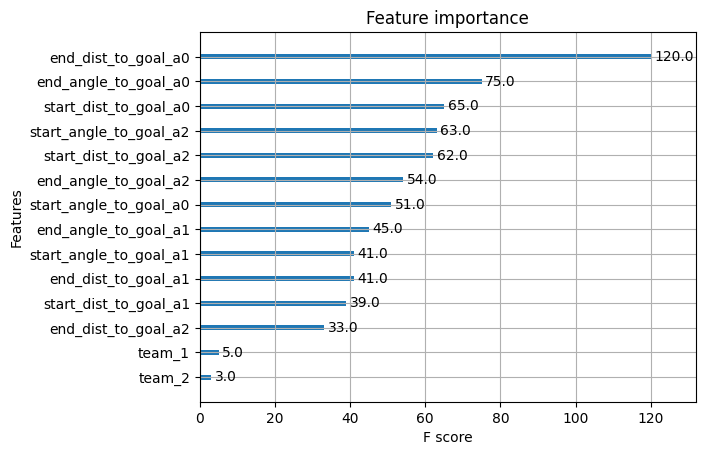

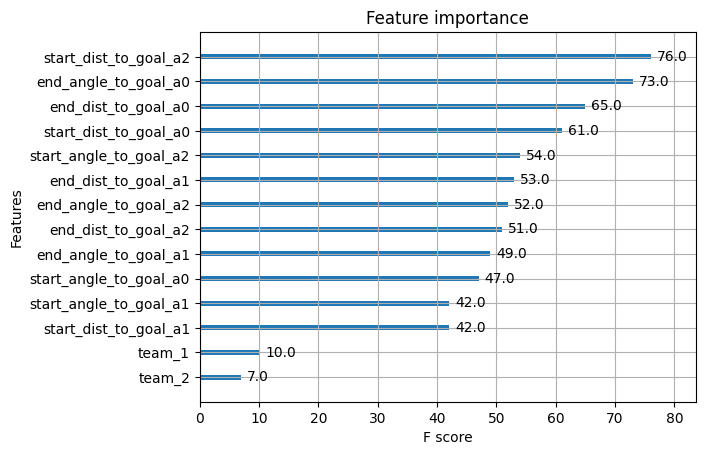

In [80]:
for label in labels:
    plot_importance(models[label])

## Investigate SHAP values

In [67]:
import shap
from ipywidgets import fixed, interact_manual, widgets
from socceraction.vaep.formula import value

[16:19:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


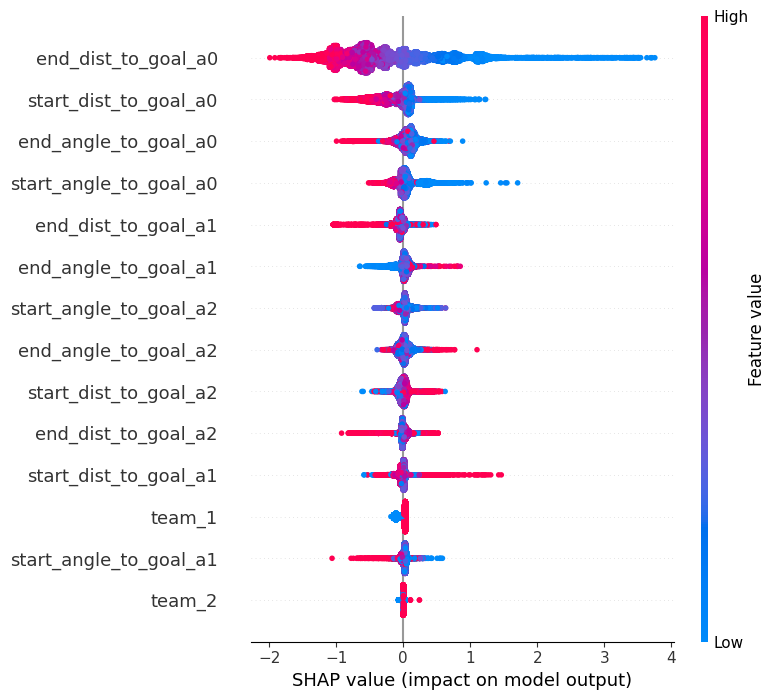

[16:19:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


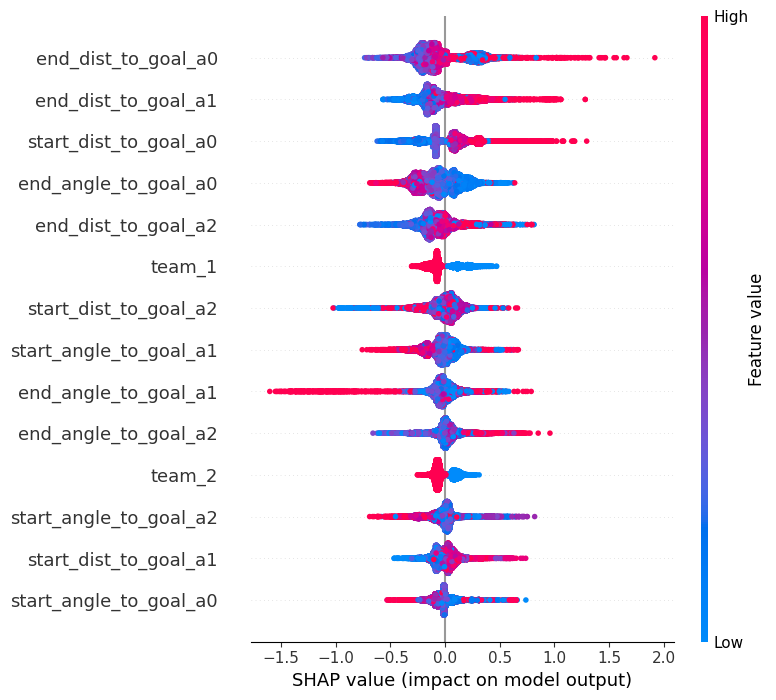

In [82]:
#label='scores'
# label='concedes'
for label in labels:
    explainer = shap.TreeExplainer(models[label])

    shap_values = explainer.shap_values(df_X_test[features])
    shap.summary_plot(shap_values, df_X_test[features])

## 4.2 Estimate the probabilities

In [148]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_features[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_features.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


In [84]:
df_predictions.to_csv('predictions.csv', index=False)

# Load actions, players and teams and value actions

In [5]:
import socceraction.spadl as spadl

In [6]:
last_games = pd.read_csv('last_premier_games.csv')

In [ ]:
dfs_actions = []
for row in last_games.itertuples(): #zip(last_games['game_id'].values, last_games['home_team_id'].values):
    game_id = row.game_id
    
    #print(f'Processing game {game_id}')
    df_actions = pd.read_hdf('actions.h5', key=f'game_{game_id}')
    team_name = pd.read_hdf('teams.h5', key=f'game_{game_id}')
    player_name = pd.read_hdf('players.h5', key=f'game_{game_id}')
    df_actions = (spadl
        #df_actions#spadl
        .add_names(df_actions)  # add actiontype and result names
        .merge(team_name, how='left')  # add team names
        .merge(player_name, how='left')  # add player names
        #.sort_values(["game_id", "period_id", "action_id"])
        .reset_index()
        .rename(columns={'index': 'action_id'})
    )
    dfs_actions.append(df_actions)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

In [152]:
df_predictions = pd.read_csv('predictions.csv')
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)

In [90]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions.groupby('game_id'):
    df_values = value(game_predictions, game_predictions['scores'], game_predictions['concedes'])
    
    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

## Rate players

We investigate the ratings per player and look at the quantity-quality trade-off, risk-reward trade-off and the rating per player per action type (e.g. shot, pass, tackle, etc.)

In [115]:
df_ranking = (df_values[['player_id', 'team_name', 'nickname', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'nickname'])
    .agg(vaep_count=('vaep_value', 'count'), 
         vaep_mean=('vaep_value', 'mean'),
         vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

- I left here, still need to replicate the results of the video and add the code for the plots, since right now it is saying the actions per game is only about 1 or two, which is not true.

In [129]:
df_player_games = []
for row in spanish_2017.itertuples():
    game_id = row.game_id
    game_player = pd.read_hdf('players.h5', key=f'game_{game_id}')
    df_player_games.append(game_player)

df_player_games = pd.concat(df_player_games).reset_index(drop=True)
df_minutes_played = df_player_games.groupby(['player_id'])['minutes_played'].sum().reset_index()
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

In [131]:
MIN_THRESHOLD = 450
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)
df_ranking_p90.head(10)

,player_id,team_name,nickname,vaep_count,vaep_mean,vaep_sum,minutes_played,vaep_rating,actions_p90
0,3359,FC Barcelona,L. Messi,2714,0.015703,42.618678,3127,1.226633,78.113208
3,86319,UD Las Palmas,L. Chichizola,1316,0.020499,26.976041,2540,0.955844,46.629921
5,247206,Reial Club Deportiu Espanyol,Pau López,905,0.029167,26.396560,2690,0.883156,30.278810
13,3330,Levante UD,Oier,824,0.029075,23.957455,2450,0.880070,30.269388
15,3322,Real Madrid Club de Fútbol,Cristiano Ronaldo,1140,0.020368,23.219652,2382,0.877317,43.073048
10,3915,Real Madrid Club de Fútbol,K. Navas,767,0.032105,24.624208,2536,0.873887,27.220032
324,215265,Valencia CF,Jaume Doménech,158,0.028531,4.507963,469,0.865068,30.319829
223,3399,Girona FC,Gorka Iraizoz,279,0.027397,7.643683,797,0.863151,31.505646
155,3398,Levante UD,Raúl Fernández,378,0.026065,9.852550,1037,0.855091,32.806172
1,3299,Deportivo Alavés,Fernando Pacheco,1179,0.028018,33.033519,3513,0.846290,30.204953


## Quantity - quality trade-off
In the next cell we create a figure to analyze the quantity-quality trade-off. The VAEP rating per player per 90 minutes depends on the average rating per action and the number of actions per 90 minutes. Some players have high ratings because they execute a lot of actions per 90 minutes, while others have very high average ratings.

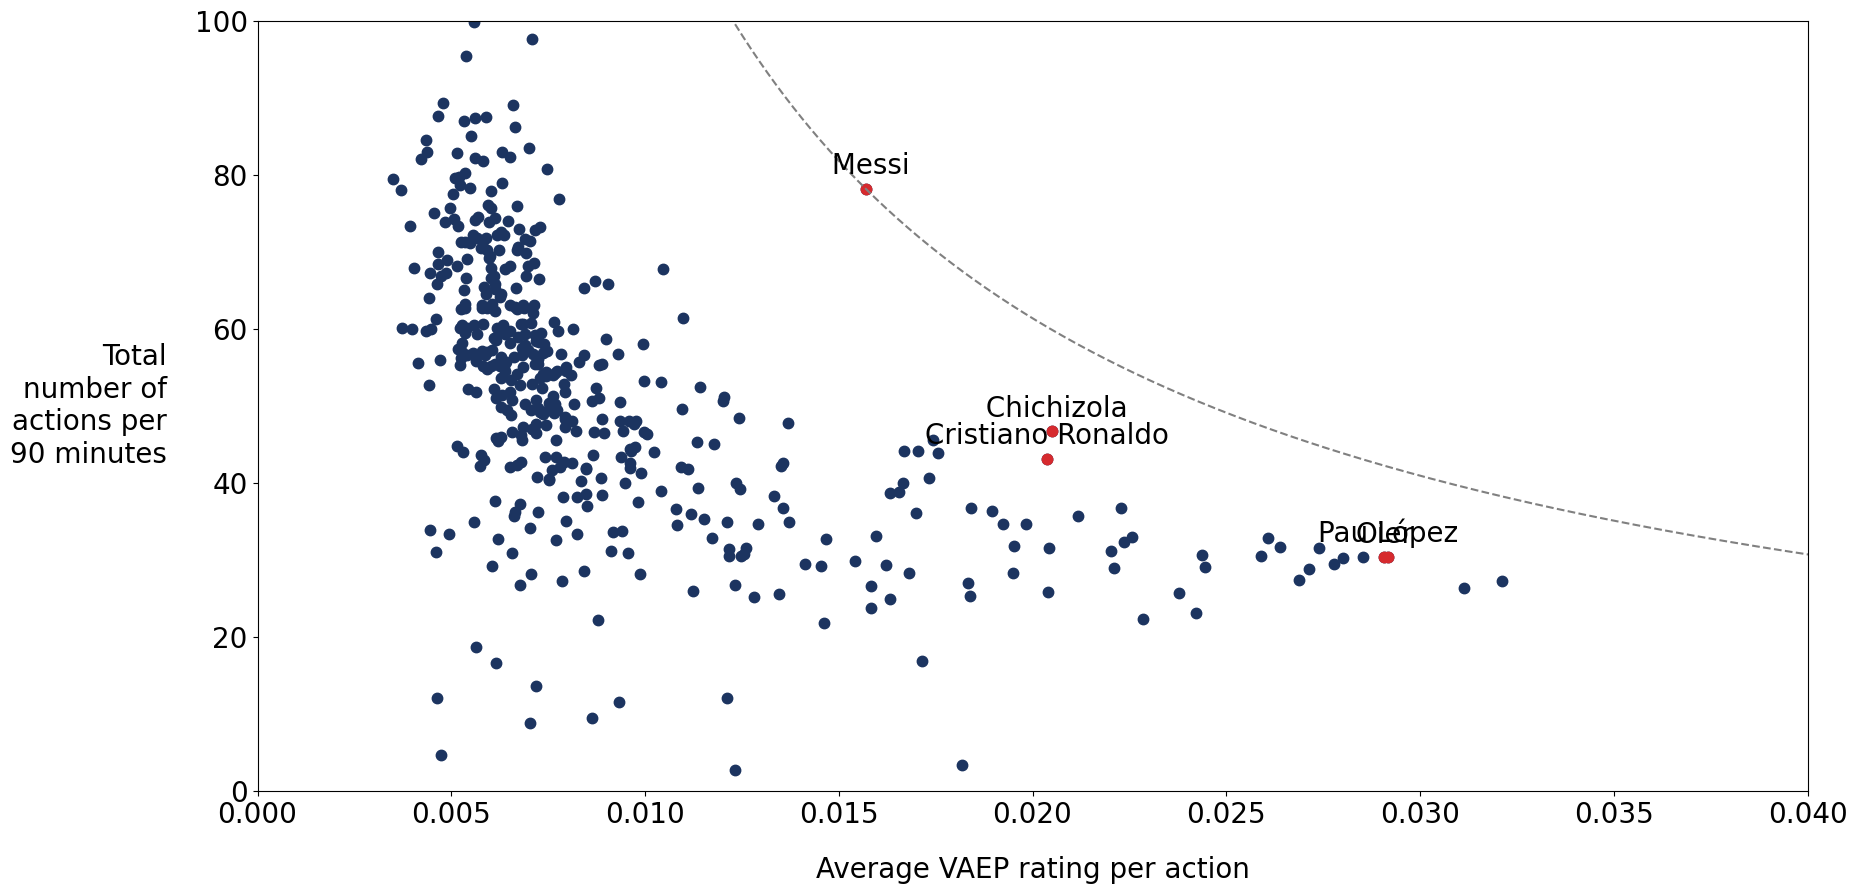

In [128]:
plt.figure(figsize=(20, 10))
x = list(df_ranking_p90['vaep_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_ranking_p90['vaep_mean'][0:5])
y_best = list(df_ranking_p90['actions_p90'][0:5])
names = list(df_ranking_p90['nickname'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')

best_player = x[0] * y[0]
yi = np.arange(0.1, 100, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.04)
plt.ylim(0, 100)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()

I left here. The issue came from making prediction on only the test set, which is not enough to get the right number of actions per player. I need to make predictions on the whole dataset and then get the number of actions per player.

In [135]:
df_risk = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'nickname', 'team_name'],
                                              columns=['result_name'], aggfunc='sum',
                                              fill_value=0)[['success', 'fail']]

In [136]:
df_risk = df_risk.reset_index()
df_risk = df_risk[0:-1]
df_risk = pd.merge(df_risk, df_minutes_played, on=['player_id'])
for result in ['success', 'fail']:
    df_risk[result] = df_risk[result] / df_risk['minutes_played'] * 90

In [137]:
df_risk

,player_id,nickname,team_name,success,fail,minutes_played
0,33,J. Cillessen,FC Barcelona,0.791830,0.049739,93
1,99,P. Tytoń,Real Club Deportivo de La Coruña,0.300609,0.066276,105
2,151,J. Guidetti,Deportivo Alavés,0.234720,0.158989,1388
3,151,J. Guidetti,Real Club Celta de Vigo,0.011234,0.048902,1388
4,254,R. Rosales,Málaga Club de Fútbol,0.325380,0.151591,3261
...,...,...,...,...,...,...
566,516397,Mujaid Sadick,Real Club Deportivo de La Coruña,0.184586,0.067855,110
567,519496,Fabio González,UD Las Palmas,0.375288,0.089703,65
568,520163,Diego Barri,Getafe Club de Fútbol,0.173930,0.084635,124
569,545811,Hugo Duro,Getafe Club de Fútbol,0.055311,0.201162,24


In [138]:
df_risk = df_risk[df_risk['minutes_played']>MIN_THRESHOLD]
df_risk['vaep_rating'] = df_risk['success'] + df_risk['fail']
df_risk.sort_values('fail')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,player_id,nickname,team_name,success,fail,minutes_played,vaep_rating
425,247222,Álvaro Medrán,Valencia CF,0.016439,0.005189,1065,0.021628
494,293862,Nacho Gil,Valencia CF,0.043223,0.011469,999,0.054691
152,3970,Alejandro Gálvez,SD Eibar,0.089977,0.017300,2060,0.107277
114,3704,Pape Diop,Reial Club Deportiu Espanyol,0.038683,0.021894,1267,0.060577
392,215265,Jaume Doménech,Valencia CF,0.843077,0.021990,469,0.865068
...,...,...,...,...,...,...,...
249,7972,L. Suárez,FC Barcelona,0.479786,0.312768,3015,0.792555
291,25795,W. Ben Yedder,Sevilla FC,0.297245,0.323263,1787,0.620508
26,3322,Cristiano Ronaldo,Real Madrid Club de Fútbol,0.465058,0.401546,2382,0.866605
41,3359,L. Messi,FC Barcelona,0.801321,0.406086,3127,1.207407


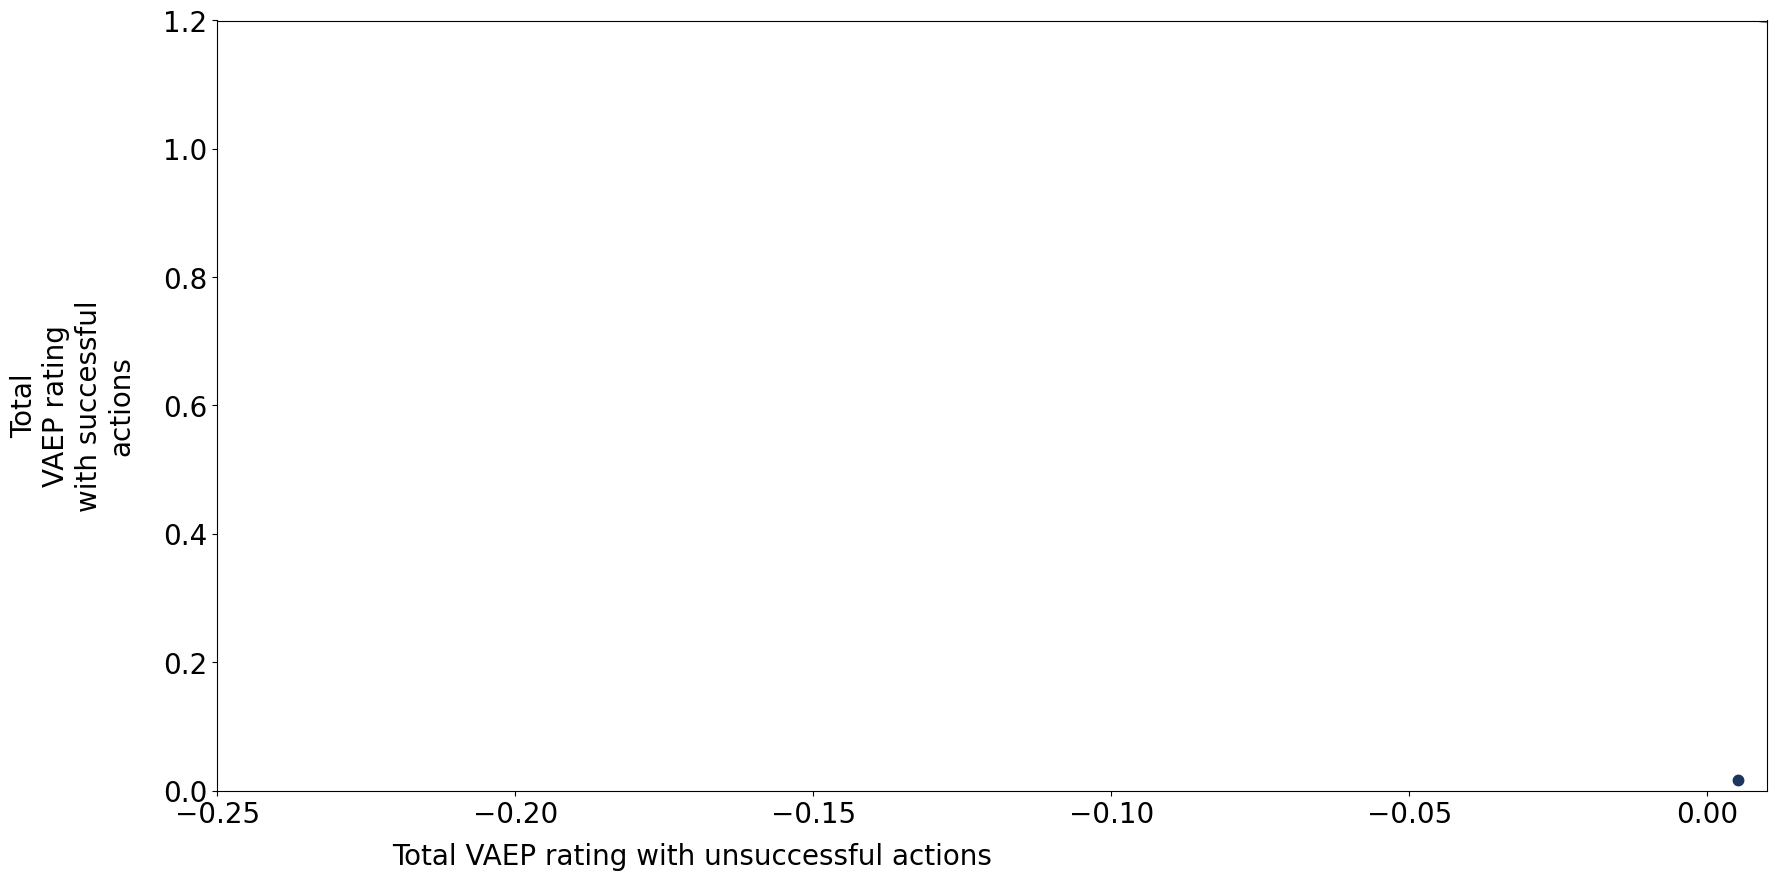

In [140]:
df_risk = df_risk.sort_values('vaep_rating', ascending=False)

plt.figure(figsize=(20, 10))
x = list(df_risk['fail'])
y = list(df_risk['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_risk['fail'][0:5])
y_best = list(df_risk['success'][0:5])
names = list(df_risk['nickname'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, horizontalalignment='center')

best_player = x[0] + y[0]
yi = np.arange(0.1, 2, 0.1)
xi = [best_player - i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.25, 0.01)
plt.ylim(0, 1.2)
plt.xlabel('Total VAEP rating with unsuccessful actions', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)
plt.ylabel('Total\nVAEP rating\nwith successful\nactions', labelpad=20, fontsize=20)

plt.show()

# Rating action per type

In [142]:
df_rating_action = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'nickname', 'team_name'],
                                              columns=['type_name'], aggfunc=np.sum,
                                              fill_value=0, margins=True, margins_name='total')
df_rating_action = df_rating_action.reset_index()
df_rating_action = df_rating_action[0:-1]
df_rating_action = pd.merge(df_rating_action, df_minutes_played, on=['player_id'])
for action in df_values['type_name'].unique():
    df_rating_action[action] = df_rating_action[action] / df_rating_action['minutes_played'] * 90

The provided callable <function sum at 0x7ff5f1d3b9a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function sum at 0x7ff5f1d3b9a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
The provided callable <function sum at 0x7ff5f1d3b9a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


In [143]:
df_rating_action[df_rating_action['minutes_played']>MIN_THRESHOLD].sort_values('shot', 
                                                                               ascending=False).head(10)

,player_id,nickname,team_name,bad_touch,clearance,corner_crossed,corner_short,cross,dribble,foul,...,keeper_save,pass,shot,shot_freekick,shot_penalty,tackle,take_on,throw_in,total,minutes_played
26,3322,Cristiano Ronaldo,Real Madrid Club de Fútbol,0.0,0.004618,0.000000,-0.003940,0.048539,0.023819,0.000678,...,0.0,0.106529,0.665304,0.023782,-0.022084,-0.000184,0.006332,0.004537,23.219652,2382
41,3359,L. Messi,FC Barcelona,0.0,0.000000,-0.009527,-0.015594,0.029857,0.062332,0.004492,...,0.0,0.394361,0.540418,0.126246,-0.032195,0.000619,0.058508,0.000667,42.618678,3127
249,7972,L. Suárez,FC Barcelona,0.0,0.005869,0.000000,-0.000920,0.014519,0.028171,0.009670,...,0.0,0.134933,0.532505,0.021288,-0.002721,-0.002973,0.021327,0.000380,26.552433,3015
399,225946,A. Sanabria,Real Betis Balompié,0.0,0.002538,0.000000,0.000000,0.004118,0.006789,0.013952,...,0.0,0.035071,0.473476,0.000000,0.000000,0.003204,0.006943,0.000000,5.640576,909
215,5147,A. Lozano,Girona FC,0.0,0.001481,0.000000,0.000000,0.030624,0.046191,0.020588,...,0.0,0.083968,0.463441,0.000000,0.000000,0.000063,0.023556,0.000000,3.811722,499
291,25795,W. Ben Yedder,Sevilla FC,0.0,0.000319,0.000000,0.000000,0.024596,0.016657,0.003444,...,0.0,0.095944,0.460307,0.000025,0.000000,0.000000,0.013775,0.000000,12.306216,1787
118,3714,C. Stuani,Girona FC,0.0,0.010671,0.000000,0.000000,0.004166,0.004216,0.039634,...,0.0,0.050704,0.436419,0.000000,-0.064927,0.001623,0.004805,0.000000,15.841675,2802
427,250885,Santi Mina,Valencia CF,0.0,0.010308,0.000000,0.000000,0.024566,0.030643,0.009463,...,0.0,0.089488,0.412840,0.001316,-0.017237,0.003411,0.021628,0.001552,11.428800,1633
252,8278,G. Bale,Real Madrid Club de Fútbol,0.0,0.003266,0.000000,0.000000,0.073562,0.008029,0.006772,...,0.0,0.095142,0.395898,0.004114,-0.032804,0.001285,0.008025,0.008809,12.441548,1872
537,395636,M. Gómez,Real Club Celta de Vigo,0.0,0.005287,0.000000,0.000000,0.019802,0.015415,0.015090,...,0.0,0.062626,0.367195,0.000593,0.000000,0.001678,0.006664,0.000721,18.524760,3176


## 4.3 Evaluate the probabilities

### 4.3.1 Compute base rate probabilities

The following cell computes the base rate or prior probability of each class label in the training set. We use the base rate as a naive estimate for each example in the test set being true to establish a baseline for the evaluation metrics.

The `np.full()` function in NumPy is used to create a new array of given shape and type, filled with a fill value. Here's the syntax of the `np.full()` function:

```python
numpy.full(shape, fill_value, dtype=None, order='C')
```

Parameters:

- `shape`: Shape of the new array, e.g., `(2, 3)` or `2`.
- `fill_value`: Fill value.
- `dtype` (optional): The desired data type for the array. If not given, then the type will be determined as the minimum type required to hold the objects in the sequence.
- `order` (optional): Whether to store multidimensional data in row-major (C-style) or column-major (Fortran-style) order in memory.

Here's an example of how to use the `np.full()` function:

```python
import numpy as np

# Create a new 2x3 array filled with 7
arr = np.full((2, 3), 7)

print(arr)
```

Output:

```
[[7 7 7]
 [7 7 7]]
```

In this example, `np.full((2, 3), 7)` creates a new 2x3 array filled with 7.

In [110]:
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
    })

In [111]:
df_base_rates.head()

,scores
0,0.016635
1,0.016635
2,0.016635
3,0.016635
4,0.016635


## 4.3.2 Compute Brier score loss for goal scored model

In [112]:
from sklearn.metrics import brier_score_loss, roc_auc_score

The following computes the Brier loss score for the base rate predictions

In [113]:
brier_score_loss(
    y_true = df_y_test['scores'],
    y_prob = df_base_rates['scores']
)

0.016345674157274084

The following computes the Brier loss score for the prediction by the learned model.

In [114]:
brier_score_loss(
    y_true = df_y_test['scores'],
    y_prob = df_predictions['scores']
)

0.01508935457762824

We can also make the same calculation for conceded goals

In [ ]:
#brier_score_loss(
#    y_true = df_y_test['conceded'],
#    y_prob = df_base_rates['conceded']
#)

#brier_score_loss(
#    y_true = df_y_test['conceded'],
#    y_prob = df_predictions['conceded']
#)

## 4.3.4 Plot the calibration curve and probability histogram

In [115]:
from scikitplot.metrics import plot_calibration_curve

<Axes: ylabel='Frequency'>

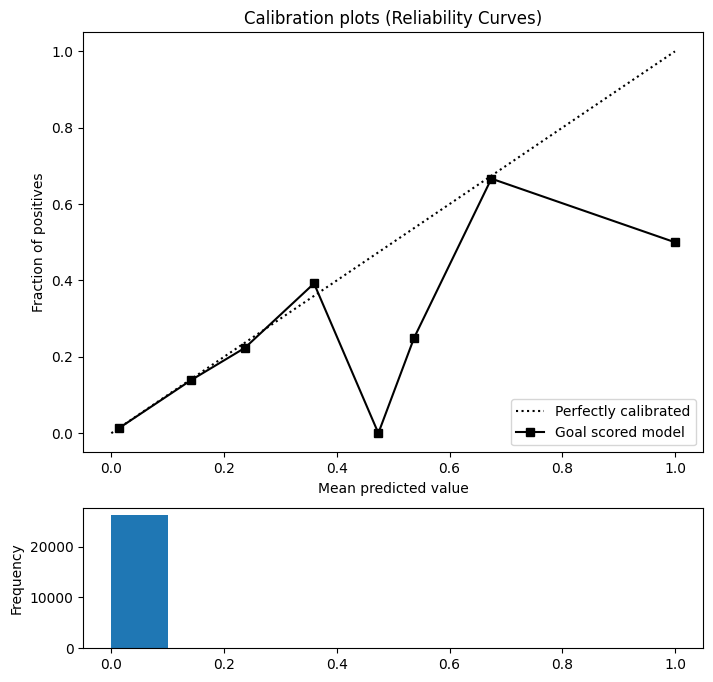

In [116]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={'height_ratios':[3, 1]
    }
)
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)

df_predictions['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2
)

# 5 Optimize classifiers

In [117]:
labels

['scores']

In [118]:
features

['start_dist_to_goal_a0',
 'end_dist_to_goal_a0',
 'start_dist_to_goal_a1',
 'end_dist_to_goal_a1',
 'start_dist_to_goal_a2',
 'end_dist_to_goal_a2',
 'start_angle_to_goal_a0',
 'end_angle_to_goal_a0',
 'start_angle_to_goal_a1',
 'end_angle_to_goal_a1',
 'start_angle_to_goal_a2',
 'end_angle_to_goal_a2',
 'team_1',
 'team_2']

In [125]:
%%time
models_cv = {}
for label in tqdm(labels):
    model_cv = GridSearchCV(
        estimator=XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
        ),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [3, 4]
        },
        scoring='neg_brier_score',
        refit=True,  # train final model on full training set using best hyperparameters
        verbose=10,
        n_jobs=1
    )
    model_cv.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models_cv[label] = model_cv

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 1/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.6s
[CV 2/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 2/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.6s
[CV 3/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 3/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.6s
[CV 4/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 4/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.5s
[CV 5/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 5/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.015 total time=   0.5s
[CV 1/5; 2/4] START max_depth=3, n_estimators=100...............................
[CV 1/5; 2/4] END max_depth=3, n_estimators=100;,

100%|██████████| 1/1 [00:14<00:00, 14.54s/it]

CPU times: user 45.6 s, sys: 440 ms, total: 46.1 s
Wall time: 14.5 s


**Note**: We have considered a manually selected set of features to represent the game states. In addition to optimizing the hyperparameters for the learning algorithm, we could also optimize the set of features to be considered by the learning algorithm. However, the XGBoost algorithm should be able to figure out by itself which features are most important to include in the model by the nature of the algorithm.

## Estimate probabilities
The following cell estimates the probabilities for each label using the trained baseline models.

In [126]:
dfs_predictions_cv = {}
for label in tqdm(labels):
    model_cv = models_cv[label]
    probabilities_cv = model_cv.predict_proba(
        df_X_test[features]
    )
    predictions_cv = probabilities_cv[:, 1]
    dfs_predictions_cv[label] = pd.Series(predictions_cv, index=df_X_test.index)
df_predictions_cv = pd.concat(dfs_predictions_cv, axis=1)

100%|██████████| 1/1 [00:00<00:00, 29.99it/s]


## Evaluate probabilities
Compute Brier score loss for goal scored model
The following cell computes the Brier loss score for the base rate predictions.

In [127]:
df_predictions_cv

,scores
173282,0.006048
108467,0.018980
158101,0.018011
202342,0.012674
239227,0.002950
...,...
34893,0.009223
172422,0.003619
16038,0.019519
240169,0.048216


In [128]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.016345674157274084

In [129]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions_cv['scores']
)

0.014939322764307632

## Plot calibration curve and probability histogram
The following cell creates a plot to show both a calibration curve and a probability histogram.

<Axes: ylabel='Frequency'>

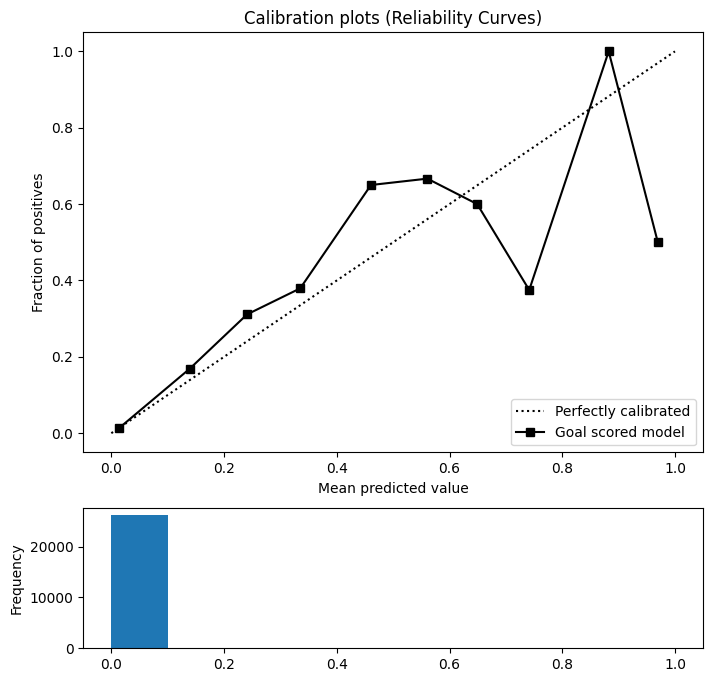

In [130]:
fig_cv, (ax1_cv, ax2_cv) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)

plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions_cv['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1_cv
)

df_predictions_cv['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2_cv
)

### Optional: Calibrate probabilities

If the trained model produces poorly calibrated probability estimates, the probability estimates can be re-calibrated using ``CalibratedClassifierCV``, which performs probability calibration with isotonic regression or logistic regression.

### Construct final classifiers
Once we have found the best feature set and best hyperparameters for the learning algorithm, we can learn the final model.

If we use GridSearchCV and the refit parameter was set to True, we can retrieve the final model, which has been re-trained on the entire training set, by accessing the best_estimator_ attribute of the object.
We can manually train the final model by creating a XGBClassifier object using the best hyperparameters and calling the fit method with the entire training set.

### Option 1: Retrieve classifier from grid search

In [131]:
model_scores = models_cv['scores']

In [132]:
pd.Series(
    model_scores.best_params_
)

max_depth        3
n_estimators    50
dtype: int64

In [133]:
pd.DataFrame(
    model_scores.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.520530,0.041532,0.043542,0.000666,3,50,"{'max_depth': 3, 'n_estimators': 50}",-0.015245,-0.015141,-0.015237,-0.015393,-0.015278,-0.015259,0.000081,1
1,0.709852,0.028617,0.049815,0.000813,3,100,"{'max_depth': 3, 'n_estimators': 100}",-0.015262,-0.015152,-0.015255,-0.015425,-0.015354,-0.015290,0.000093,2
2,0.552396,0.011591,0.046688,0.000739,4,50,"{'max_depth': 4, 'n_estimators': 50}",-0.015266,-0.015147,-0.015313,-0.015441,-0.015342,-0.015302,0.000096,3
3,0.795461,0.050197,0.056129,0.000383,4,100,"{'max_depth': 4, 'n_estimators': 100}",-0.015304,-0.015243,-0.015360,-0.015471,-0.015461,-0.015368,0.000089,4


In [134]:
pd.Series(
    model_scores.best_estimator_.get_params()
)

objective                  binary:logistic
base_score                            None
booster                               None
callbacks                             None
colsample_bylevel                     None
colsample_bynode                      None
colsample_bytree                      None
device                                None
early_stopping_rounds                 None
enable_categorical                   False
eval_metric                        logloss
feature_types                         None
gamma                                 None
grow_policy                           None
importance_type                       None
interaction_constraints               None
learning_rate                         None
max_bin                               None
max_cat_threshold                     None
max_cat_to_onehot                     None
max_delta_step                        None
max_depth                                3
max_leaves                            None
min_child_w

In [135]:
model_scores_final = model_scores.best_estimator_

In [136]:
model_scores_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Option 2: Train classifier using optimal hyperparameters
The following cell constructs a new XGBoostClassifier object using the best hyperparameters that were found by the grid search.

In [137]:
model_scores_final = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=50,
    max_depth=3
)

In [138]:
model_scores_final.fit(
    X=df_X_train[features],
    y=df_y_train[label]
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)